In [ ]:
# !pip uninstall --yes fastcore && pip install --upgrade git+git://github.com/fastai/fastcore.git 

In [ ]:
# !pip uninstall --yes fastai2 && pip install --upgrade git+git://github.com/fastai/fastai2.git

# Hebrew ULMFiT from scratch

In [1]:
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.text.all import *
torch.cuda.set_device(0)

In [2]:
bs = 96
wd = 1e-1
moms = (0.95, 0.85, 0.95)#(0.8,0.7,0.8)#
seq_len = 72

In [3]:
lang = 'he'
data_path = Config.config_path/'data'
name = f'{lang}wiki'
tok = 'SP_fwd_qrnn_v2'
text_path = data_path/name
path = Path(f'{data_path}/{name}_{tok}')
data_format = 'token' #morph or token
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt_{tok}', f'{lang}_wt_vocab_{tok}']

## Hebrew wikipedia model

### Create pretrained model

In [4]:
# tokenize_folder(text_path, output_dir=path, tok_func=SentencePieceTokenizer, lang='he',
                #max_vocab_sz=15000,
#                 sp_model=None)

In [5]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [6]:
counter = pickle.load(open(str(path/'counter.pkl'), 'rb'))
vocab = make_vocab(counter)
len(vocab)

31136

In [7]:
# texts = get_text_files(path)
# splits = RandomSplitter(valid_pct=0.01, seed=42)(texts)
# x_tfms = [Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
#           Numericalize(vocab=vocab)]
# dsets = Datasets(texts, [x_tfms], splits=splits, dl_type=LMDataLoader)
# data = dsets.dataloaders(bs=bs, seq_len=seq_len)

In [8]:
# learn = language_model_learner(data, AWD_QRNN, metrics=[accuracy, Perplexity()], path=path,
#                                drop_mult=0., pretrained=False)

In [9]:
# learn.unfreeze()
# learn.lr_find()

In [10]:
# lr = 1e-3
# lr *= bs/48  # Scale learning rate by batch size

In [11]:
# learn.unfreeze()
# learn.fit_one_cycle(15, lr, wd=wd, moms=(0.8,0.7,0.8))

In [12]:
# learn.show_results()

In [13]:
# mdl_path = path/'models'
# mdl_path.mkdir(exist_ok=True)
# learn.save(mdl_path/lm_fns[0], with_opt=False)
# with open(mdl_path/(lm_fns[1] + '.pkl'), 'wb') as f:
#     pickle.dump(learn.dls.vocab, f)

Save the pretrained model and vocab:

## Hebrew sentiment analysis

### Language model

- [Data](https://github.com/ngxbac/aivivn_phanloaisacthaibinhluan/tree/master/data)
- [Competition details](https://www.aivivn.com/contests/1)
- Top 3 f1 scores: 0.900, 0.897, 0.897

In [14]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df.head()

,comment,label
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד צער,0
1,איש יקר שלנו,0
2,כל הכבוד והמון בהצלחה,0
3,"תל חי , רובי . בכל העצב הזה היית קרן אור של תקוה . אכן יש נשיא בישראל",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0


In [15]:
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df.head()

,comment,label
0,"שמע ישראל , השם ישמור ויקרא הגורל = ( י.ק.ו.ק . ) אימרו אמן לאבא השם שלנו ! ! ! ! אחרי ברכה של ביבי ! הכח בישראל הוא מתי שיש משמעת ופרגמתיות במשרדי החינוך שזה איתן את האור ! שמאוד חסר לנו ! , והתאחדות באחד שלם , ואין שמאל ואין ימין ! ובישראל נקודה חשובה היא , תעשיית כוח פרגמטיבית ! https://www.youtube.com/watch?v=_rKMXgPQSj8 . עוד מעת אהיה ראש חודש תעברו על ה תפילה של התיקון הכללי ו תדליקו את הנר !",0
1,איחולי הצלחה בתפקידך .,0
2,כל הכבוד !!!,0
3,"בוקר טוב ישראל בוקר טוב לכבוד נשיא מדינת ישראל . ״ אשרי העם שנבחר אדם עשיר בענווה , יושרה ודעת ״ מי ייתן ותאחד את עמך ישראל . יישר כוח . עופר אלפסי מאילת .",0
4,איפה הגינוי ? http://www.iba.org.il/bet/bet.aspx?type=1&entity=1023105,1


In [16]:
full_df = pd.concat([train_df,test_df], sort=False)

In [17]:
full_df = full_df.rename(columns={'comment': 'text'})
full_df.head()

,text,label
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד צער,0
1,איש יקר שלנו,0
2,כל הכבוד והמון בהצלחה,0
3,"תל חי , רובי . בכל העצב הזה היית קרן אור של תקוה . אכן יש נשיא בישראל",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0


In [18]:
tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
splits = RandomSplitter(valid_pct=0.01, seed=42)(full_df)
dsrc = Datasets(full_df, [tfms], splits=splits, dl_type=LMDataLoader)
data_ft = dsrc.dataloaders(bs=bs, seq_len=seq_len)

In [19]:
learn_lm = language_model_learner(data_ft, AWD_QRNN, metrics=[accuracy], path=path,
                                  opt_func = partial(Adam, wd=0.1),
                                  drop_mult=0.5, pretrained_fnames=lm_fns)
learn_lm.loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#

(0.04365158379077912, 0.019054606556892395)

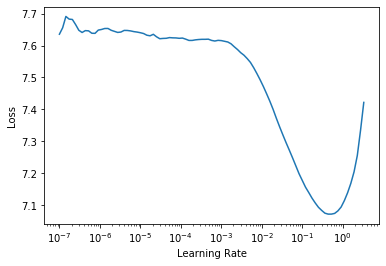

In [20]:
learn_lm.lr_find()

In [21]:
lr = 2e-1
lr *= bs/48
n_epochs = 4

In [22]:
learn_lm.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,6.916131,6.881635,0.176442,00:36
1,7.176234,6.669805,0.179327,00:36
2,6.815047,6.143544,0.226282,00:36
3,6.246258,5.799484,0.249038,00:40


In [23]:
learn_lm.unfreeze()
lr /= 5
learn_lm.fit_one_cycle(2*n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,5.687788,5.567488,0.249679,00:41
1,5.547730,5.407819,0.277083,00:41
2,5.382226,5.213578,0.295513,00:42
3,5.117649,4.875687,0.332692,00:43
4,4.757025,4.689608,0.354006,00:43
5,4.283674,4.207784,0.421154,00:42
6,3.791655,3.978199,0.463942,00:41
7,3.482307,3.933268,0.473237,00:43


In [24]:
learn_lm.save(f'{lang}fine_tuned_{tok}_{data_format}')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_{tok}_{data_format}')

### Classifier

Full train set
--

In [25]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df['is_valid'] = False
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df['is_valid'] = True

df = pd.concat([train_df,test_df], sort=False).rename(columns={'comment': 'text'})

In [26]:
bs = 64
splits = ColSplitter()(df)
x_tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
dsrc = Datasets(df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len)

In [27]:
del data_ft, learn_lm
# del learn_c
torch.cuda.empty_cache()
torch.cuda.memory.empty_cache()

In [34]:
drop = 0.
wd = 0.1
pretrained = False
loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#
learn_c = text_classifier_learner(cls_data, AWD_QRNN, 
                                  metrics=[accuracy, BalancedAccuracy()],
                                  path=path,
                                  loss_func=loss_func,
                                  drop_mult=drop, pretrained=pretrained, wd=wd)
learn_c = learn_c.load_encoder(f'{lang}fine_tuned_enc_{tok}_{data_format}')

(0.04365158379077912, 0.12022644281387329)

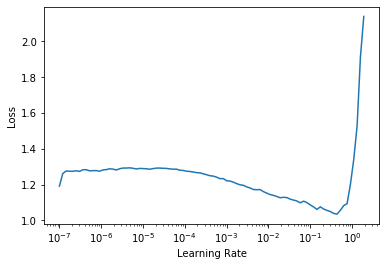

In [35]:
# learn_c.lr_find()

In [36]:
lr = 3e-2
lr *= bs/48
n_epochs = 5
div = 10.0

In [37]:
learn_c.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms, div=div)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.761525,0.629635,0.841797,0.635756,00:07
1,0.753604,0.596780,0.843359,0.595897,00:09
2,0.751040,0.592123,0.850391,0.637141,00:08
3,0.719132,0.582092,0.834766,0.700234,00:08
4,0.701573,0.589471,0.856641,0.662675,00:07
5,0.639402,0.610247,0.852344,0.697348,00:07
6,0.605044,0.612145,0.873047,0.709173,00:08
7,0.598108,0.620437,0.873828,0.699412,00:08


In [38]:
learn_c.freeze_to(-2)
#lr /= 2
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.569908,0.601699,0.862109,0.640854,00:08
1,0.549474,0.526860,0.881641,0.716425,00:08
2,0.506852,0.577734,0.880859,0.741516,00:08
3,0.449021,0.500374,0.902734,0.717482,00:08
4,0.419004,0.516948,0.899219,0.737644,00:09
5,0.368574,0.460614,0.922656,0.796329,00:09
6,0.344744,0.454753,0.932813,0.810074,00:08
7,0.337264,0.441523,0.928906,0.811947,00:08


In [39]:
learn_c.freeze_to(-3)
lr /= 2
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.349873,0.467053,0.928125,0.794339,00:12
1,0.431027,0.492920,0.897656,0.722974,00:10
2,0.408987,0.469242,0.914453,0.766802,00:10
3,0.358939,0.460011,0.917578,0.787167,00:10
4,0.347887,0.433214,0.934375,0.815598,00:11
5,0.339880,0.437878,0.935156,0.820875,00:11
6,0.330162,0.426932,0.938281,0.811323,00:11
7,0.325641,0.430270,0.938281,0.815982,00:10


In [40]:
learn_c.freeze_to(-4)
lr /= 2
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.324738,0.423588,0.938672,0.814824,00:14
1,0.335039,0.434900,0.933594,0.808290,00:13
2,0.354888,0.446311,0.934375,0.806121,00:15
3,0.335979,0.443776,0.933594,0.823023,00:13
4,0.332351,0.430437,0.938281,0.806889,00:13
5,0.328533,0.422580,0.939844,0.818346,00:14
6,0.325324,0.426192,0.937891,0.809096,00:13
7,0.321464,0.421452,0.940234,0.819671,00:13


In [41]:
learn_c.unfreeze()
lr /= 2
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.319679,0.419510,0.942187,0.823957,00:18
1,0.331221,0.433389,0.938281,0.815305,00:20
2,0.325748,0.418286,0.942187,0.818396,00:19
3,0.324235,0.415717,0.941016,0.817581,00:21
4,0.322071,0.414460,0.942187,0.819073,00:19
5,0.326185,0.420640,0.941797,0.817072,00:20
6,0.325579,0.417675,0.941016,0.813148,00:21
7,0.325998,0.428393,0.939453,0.812735,00:20


In [42]:
lr /= 5
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.322489,0.415696,0.941406,0.818455,00:20
1,0.325627,0.414491,0.941797,0.814443,00:21
2,0.320519,0.418122,0.943750,0.818053,00:18
3,0.317169,0.413651,0.941016,0.814051,00:19
4,0.323299,0.425756,0.941797,0.815492,00:20
5,0.317731,0.413537,0.942578,0.814836,00:18
6,0.323720,0.414137,0.942969,0.815032,00:21
7,0.321500,0.415216,0.940234,0.814786,00:20


In [46]:
# learn_c.save(f'{lang}clas_{tok}_{data_format}_traintest')

In [50]:
from fastai2.interpret import *
interp = ClassificationInterpretation.from_learner(learn_c)
interp.plot_top_losses(50)

,input,target,predicted,probability,loss
0,"▁xxbos ▁חברים ▁יקר ים ▁ , ▁עוד ▁מעט ▁תת חיל ▁ישיבת ▁ קבינט ▁ושם ▁יו ח לט ▁על ▁המשך ▁הפעולה ▁המשך ▁הפעולה ▁צריך ▁להיות ▁סיפוח ▁מחדש ▁של ▁גוש ▁קטיף ▁וה רצועה ▁תוך ▁כניסה ▁לע זה ▁לעשות ▁שם ▁סדר ▁באו סלו ▁נתנו ▁את ▁יו "" ש ▁וקיבל נו ▁טרור ▁ , ▁מה ▁ עש ינו ▁ ? ▁ה חזר נו ▁את ▁השליטה ▁ב ▁2002 ▁ומי גר נו ▁את ▁הטרור ▁( ▁לפחות ▁את ▁המת אבד ים ▁ ) ▁כמעט ▁לגמרי ▁ . ▁הגיע ▁הזמן ▁לעשות ▁זאת ▁שוב ▁ולקח ת ▁את ▁גורל נו ▁בידי נו ▁אחרי ▁הר קט ה ▁הבאה ▁מחזיר ים ▁את ▁השטחים ▁ברצועת ▁עזה ▁ומחזיר ים ▁את ▁התושבים ▁( ▁שחלקם ▁עדיין ▁לא ▁יושב ו ▁ ) ▁הביתה ▁ומ פסיק ים ▁את ▁טרור ▁הרקטות ▁ ! ▁ http s : ▁/ ▁/ ▁xxrep ▁3 ▁w ▁ . face book . com ▁/ ▁ hi tha br ut",1,0,0.5061488151550293,4.682489395141602
1,"▁xxbos ▁הדבר ▁הנכון ▁קרה ▁ , ▁נקבע ▁ונעשה ▁ . ▁נבחרת ▁כי ▁ה יית ▁המתאים ▁ביותר ▁ . ▁אינ ך ▁חייב ▁דבר ▁לאיש ▁ , ▁ בטח ▁לא ▁לאנשי ▁המשטר ▁ . ▁תר ים ▁את ▁הכ פפה ▁ . ▁ארץ ▁ישראל ▁השלמה ▁פחות ▁חשובה ▁מחבר ה ▁בריא ה ▁ , ▁נטול ת ▁שחיתות ▁ , ▁צו דק ת ▁ומת גמל ת ▁את ▁אוהב יה ▁ . ▁המדינה ▁אינה ▁חולה ▁ . ▁פרנס יה ▁רווי ▁שחיתות ▁וח מס ▁ . ▁אם ▁לא ▁למע ננו ▁ , ▁למען ▁ילד ינו ▁ו יום ▁אחד ▁נכד ינו ▁ . ▁כ כה ▁אי ▁אפשר ▁להמשיך ▁ . ▁בהצלחה ▁ , ▁ יאר ▁פניו ▁אל יך ▁ו יח וני ך ▁את ▁השאר ▁תעשה ▁לבד ▁ .",1,0,0.961058497428894,4.34774923324585
2,▁xxbos ▁בשעה ▁קשה ▁כזו ▁ . . ▁העם ▁חייב ▁מנהיג ▁מרג יע ▁ . . ▁שי דבר ▁מה ראש ▁את ▁מה ▁שמ רגיש ▁בב טן ▁ . . ▁ואת ה ▁חייב ▁להיות ▁ככזה ▁ . .,1,0,0.9610892534255981,4.184901237487793
3,▁xxbos ▁הנשיא ▁רובי ▁היקר ▁עשה ▁למע ננו ▁ול מען ▁המשפחות ▁השק ולות ▁ישוע ה ▁ובו א ▁נ כבוש ▁את ▁עז ▁xxrep ▁11 ▁ה,1,0,0.951406717300415,4.079798221588135
4,"▁xxbos ▁יוני ▁בן ▁שלום ▁ , ▁קצת ▁כבוד ▁לנשיא ▁... . ▁תא מר ▁את ▁דבר יך ▁אבל ▁בכבוד ▁הראוי ▁ובלי ▁לכל וך ▁ !",1,0,0.9435447454452515,4.014476776123047
5,"▁xxbos ▁אכן ▁ליב נו ▁דו אב ▁ומצ טרפ ים ▁אנו ▁ל תפילות ▁ול תקוות ▁לראות ▁את ▁הבנים ▁במהרה ▁בריא ים ▁ושל מים ▁ . ▁חובה ▁על ינו ▁לדאוג ▁ש ארגוני ▁טרור ▁וחש בו ▁טוב ▁טוב ▁לפני ▁בצו ע ▁מעשי ▁טרור ▁ , ▁על ינו ▁להחזיר ▁את ▁מומנט ▁ההר ת עה ▁שאיבד נו ▁על ▁מנת ▁ש אזרחי ▁ישראל ▁יהיו ▁בטוחים ▁בבית ם ▁ .",1,0,0.9585166573524475,3.9417922496795654
6,▁xxbos ▁אני ▁לא ▁חושב ת ▁שהוא ▁ראוי ▁להיות ▁נשיא ▁המדינה ▁של י ▁ .,1,0,0.9504547119140625,3.8469386100769043
7,▁xxbos ▁אל ▁תשכ ח ▁מר ▁רובי ▁שאני ▁חזית י ▁את ▁נצ חונך ▁ללא ▁עורר ין ▁ . ▁ופרס מתי ▁ ות מכת י ▁ב ך ▁... .,2,0,0.9612142443656921,3.4137582778930664
8,▁xxbos ▁כנשיא ▁המדינה ▁את ה ▁חייב ▁לכבד ▁את ▁המסורת ▁של ▁העם ▁ ! ▁זה ▁לא ▁מביא ▁לך ▁ברכה ▁ !,1,0,0.9310285449028015,3.4105920791625977
9,▁xxbos ▁כנשיא ▁המדינה ▁את ה ▁חייב ▁לכבד ▁את ▁המסורת ▁של ▁העם ▁ ! ▁זה ▁לא ▁מביא ▁לך ▁ברכה ▁ !,1,0,0.9310285449028015,3.4105920791625977


In [51]:
test_df.iloc[np.array(interp.dl.get_idxs())[interp.top_losses(k=50)[1]]].drop_duplicates()

,comment,label,is_valid
289,"חברים יקרים , עוד מעט תתחיל ישיבת קבינט ושם יוחלט על המשך הפעולה המשך הפעולה צריך להיות סיפוח מחדש של גוש קטיף והרצועה תוך כניסה לעזה לעשות שם סדר באוסלו נתנו את יו""ש וקיבלנו טרור , מה עשינו ? החזרנו את השליטה ב 2002 ומיגרנו את הטרור ( לפחות את המתאבדים ) כמעט לגמרי . הגיע הזמן לעשות זאת שוב ולקחת את גורלנו בידינו אחרי הרקטה הבאה מחזירים את השטחים ברצועת עזה ומחזירים את התושבים ( שחלקם עדיין לא יושבו ) הביתה ומפסיקים את טרור הרקטות ! https://www.facebook.com/hithabrut",1,True
1160,"הדבר הנכון קרה , נקבע ונעשה . נבחרת כי היית המתאים ביותר . אינך חייב דבר לאיש , בטח לא לאנשי המשטר . תרים את הכפפה . ארץ ישראל השלמה פחות חשובה מחברה בריאה , נטולת שחיתות , צודקת ומתגמלת את אוהביה . המדינה אינה חולה . פרנסיה רווי שחיתות וחמס . אם לא למעננו , למען ילדינו ויום אחד נכדינו . ככה אי אפשר להמשיך . בהצלחה , יאר פניו אליך ויחוניך את השאר תעשה לבד .",1,True
2253,בשעה קשה כזו .. העם חייב מנהיג מרגיע .. שידבר מהראש את מה שמרגיש בבטן .. ואתה חייב להיות ככזה ..,1,True
2338,הנשיא רובי היקר עשה למעננו ולמען המשפחות השקולות ישועה ובוא נכבוש את עזההההההההההה,1,True
2497,"יוני בן שלום , קצת כבוד לנשיא .... תאמר את דבריך אבל בכבוד הראוי ובלי לכלוך !",1,True
1013,"אכן ליבנו דואב ומצטרפים אנו לתפילות ולתקוות לראות את הבנים במהרה בריאים ושלמים . חובה עלינו לדאוג שארגוני טרור וחשבו טוב טוב לפני בצוע מעשי טרור , עלינו להחזיר את מומנט ההרתעה שאיבדנו על מנת שאזרחי ישראל יהיו בטוחים בביתם .",1,True
1046,אני לא חושבת שהוא ראוי להיות נשיא המדינה שלי .,1,True
2120,אל תשכח מר רובי שאני חזיתי את נצחונך ללא עוררין . ופרסמתי ותמכתי בך ....,2,True
796,כנשיא המדינה אתה חייב לכבד את המסורת של העם ! זה לא מביא לך ברכה !,1,True
712,סומכים עליך שתדאג לנקות כמו שצריך למען עתיד טוב יותר,1,True


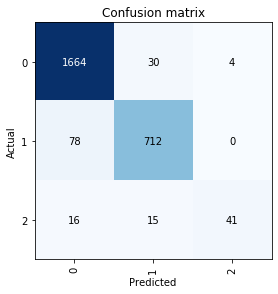

In [52]:
interp.plot_confusion_matrix()

In [ ]:
# 0 - positive
# 1 - negative
# 2 - neutral